In [1]:
from sae_lens import HookedSAETransformer

MODEL_NAME = "google/gemma-2-2b"

llm = HookedSAETransformer.from_pretrained(model_name=MODEL_NAME)

/Users/oliclive-griffin/code/mars-apps/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  9.92it/s]


Loaded pretrained model google/gemma-2-2b into HookedTransformer


In [2]:
llm.cfg.n_layers

26

In [3]:
from sae_lens import SAE  # type: ignore

SAE_NAME = "gemma-scope-2b-pt-res-canonical"
LAYERS = (1, 2, 18, 19)

In [4]:
def get_sae(layer: int):
    sae, cfg_dict, sparsity = SAE.from_pretrained(
        release = SAE_NAME,
        sae_id = f"layer_{layer}/width_16k/canonical",
    )    
    print(f"Loaded SAE for layer {layer} with sparsity: {sparsity}")
    return sae

saes = [get_sae(layer) for layer in LAYERS]

Loaded SAE for layer 1 with sparsity: None
Loaded SAE for layer 2 with sparsity: None
Loaded SAE for layer 18 with sparsity: None
Loaded SAE for layer 19 with sparsity: None


In [5]:
for sae in saes:
    sae.to('cpu')
llm.to('cpu')
None

Moving model to device:  cpu


In [6]:
# ruff: noqa: F722 # for annotations
from einops import rearrange, pack
from typing import Iterator
import torch
from datasets import load_dataset  # type: ignore

HF_DATASET_NAME = "roneneldan/TinyStories"  # "PleIAs/common_corpus"

def load_latents(sequence_length: int, llm_batch_size: int):
    dataset = load_dataset(HF_DATASET_NAME, streaming=True)

    def _tokens_iterator() -> Iterator[torch.Tensor]:
        for example in dataset["train"]:
            example_text = example["text"]

            tokens_np_S = llm.tokenizer.encode(example_text)
            tokens_S = torch.tensor(tokens_np_S)
            num_full_sequences = tokens_S.shape[0] // sequence_length
            if num_full_sequences == 0:
                continue

            sequences_NS = tokens_S[: num_full_sequences * sequence_length].split(
                sequence_length
            )
            for sequence_S in sequences_NS:
                yield sequence_S

    def _tokens_batch_iterator() -> Iterator[torch.Tensor]:
        batch_S = []  # s is shape of item
        for item_S in _tokens_iterator():
            batch_S.append(item_S)
            if len(batch_S) == llm_batch_size:
                batch_NS = torch.stack(batch_S)
                yield batch_NS
                batch_S = []
    
    def _latents_batch_iterator() -> Iterator[torch.Tensor]:
        for batch_NS in _tokens_batch_iterator():
            _, cache = llm.run_with_cache_with_saes(batch_NS, saes=saes)
            
            latents_NSH = [cache[f'blocks.{layer}.hook_resid_post.hook_sae_acts_post'] for layer in LAYERS]
            latents_NSLH, _ = pack(latents_NSH, 'N S * H')
            # flatten batch and sequence dims, we don't care about sequences
            latents_TLH = rearrange(latents_NSLH, 'N S L H -> (N S) L H') # T for "token"
            yield latents_TLH

    return _latents_batch_iterator()

# next(load_latents(32, 16))

Save the latents to disk

In [7]:
from pathlib import Path
import numpy as np
from tqdm import tqdm


GB_bytes = 2**30
DATA_DIR = Path("data")


latent_iterator = load_latents(
    sequence_length=32,
    llm_batch_size=16,
)

d_sae = saes[0].cfg.d_sae

bytes_to_persist = 2 * GB_bytes
dtype = np.float32
tokens_to_persist = int(bytes_to_persist / np.dtype(dtype).itemsize / len(LAYERS) / d_sae)

print(f"Persisting {tokens_to_persist} tokens")
buffer_NLH = np.zeros((tokens_to_persist, len(LAYERS), d_sae), dtype=dtype)

exp_dir = DATA_DIR / "latents" / HF_DATASET_NAME
exp_dir.mkdir(parents=True, exist_ok=True)

with torch.no_grad():
    for i, latents_TLH in tqdm(enumerate(latent_iterator), desc="Computing latents"):
        T = latents_TLH.shape[0]
        print(f"Saving {i}th batch of {T} tokens")
        if i * T >= tokens_to_persist:
            print(f"Reached {tokens_to_persist} tokens, stopping")
            break
        buffer_NLH[i*T:(i+1)*T] = latents_TLH.detach().cpu()
        if (i + 1) % 10 == 0:
            np.save(exp_dir / f"latents_{i}.npy", buffer_NLH[:((i+1)*T)])




huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Persisting 8192 tokens


Computing latents: 1it [00:14, 14.99s/it]

Saving 0th batch of 512 tokens


Computing latents: 2it [00:24, 11.63s/it]

Saving 1th batch of 512 tokens


Computing latents: 3it [00:31,  9.49s/it]

Saving 2th batch of 512 tokens


Computing latents: 4it [00:37,  8.16s/it]

Saving 3th batch of 512 tokens


Computing latents: 5it [00:44,  7.70s/it]

Saving 4th batch of 512 tokens


Computing latents: 6it [00:50,  7.21s/it]

Saving 5th batch of 512 tokens


Computing latents: 7it [00:55,  6.53s/it]

Saving 6th batch of 512 tokens


Computing latents: 8it [01:01,  6.25s/it]

Saving 7th batch of 512 tokens


Computing latents: 9it [01:07,  6.17s/it]

Saving 8th batch of 512 tokens
Saving 9th batch of 512 tokens


Computing latents: 11it [01:24,  7.46s/it]

Saving 10th batch of 512 tokens


Computing latents: 12it [01:31,  7.49s/it]

Saving 11th batch of 512 tokens


Computing latents: 13it [01:38,  7.24s/it]

Saving 12th batch of 512 tokens


Computing latents: 14it [01:45,  7.17s/it]

Saving 13th batch of 512 tokens


Computing latents: 14it [01:46,  7.62s/it]


KeyboardInterrupt: 

In [21]:
from collections import defaultdict
import numpy as np
from pathlib import Path

from tqdm import tqdm
import features_metric

import importlib
importlib.reload(features_metric)


# tinystories
latent_path = Path("data") / "latents" / "roneneldan/TinyStories" / "latents_9.npy"
latents_TLH = np.load(latent_path)
print(latents_TLH.shape)

T = latents_TLH.shape[0]

batch_size = 10

grids = defaultdict(list)

for latents_chunk_TLH in tqdm(np.array_split(latents_TLH, T // batch_size), desc="Computing latents"):
    for i, layeri_name in enumerate(LAYERS):
        for j, layerj_name in enumerate(LAYERS):
            # if i == j:
            #     continue
            latents_sae_i_TH = latents_chunk_TLH[:, i]
            latents_sae_j_TH = latents_chunk_TLH[:, j]

            pairwise_jaccard_similarity_DD = features_metric.pairwise_soft_jaccard(latents_sae_i_TH, latents_sae_j_TH)
            max_jaccard_D = np.max(pairwise_jaccard_similarity_DD, axis=0)
            mmj = np.mean(max_jaccard_D)
            grids[(i, j)].append(mmj)

            # grids[(i, j)].append(features_metric.mean_max_jaccard(latents_sae_i_TH, latents_sae_j_TH))

(5120, 4, 16384)


Computing latents:   1%|▏         | 7/512 [13:22<16:05:28, 114.71s/it]


KeyboardInterrupt: 

defaultdict(<class 'list'>, {(0, 0): [0.13171387, 0.03540039, 0.018127441, 0.058166504, 0.05065918, 0.040283203, 0.047790527], (0, 1): [0.33382356, 0.038481712, 0.01640779, 0.046329133, 0.039483897, 0.035746474, 0.037102513], (0, 2): [0.32561582, 0.019641872, 0.01358135, 0.017341282, 0.013205133, 0.015647281, 0.018590208], (0, 3): [0.14213988, 0.010293128, 0.00816063, 0.007605691, 0.005222114, 0.007256522, 0.008289378], (1, 0): [0.1287269, 0.033455856, 0.015990354, 0.05521574, 0.04788697, 0.038132455, 0.04524898], (1, 1): [0.33825684, 0.04046631, 0.018188477, 0.049743652, 0.0423584, 0.037841797, 0.039855957], (1, 2): [0.3445008, 0.019944735, 0.013472356, 0.017406931, 0.012878524, 0.015612011, 0.01897934], (1, 3): [0.14358816, 0.010202153, 0.007938727, 0.0076500466, 0.0051655797, 0.007197272, 0.008315101], (2, 0): [0.08135685, 0.01837702, 0.009500267, 0.027233768, 0.02241927, 0.018435072, 0.022700727], (2, 1): [0.2792969, 0.020791605, 0.009348117, 0.02434073, 0.01875519, 0.020751027, 0.

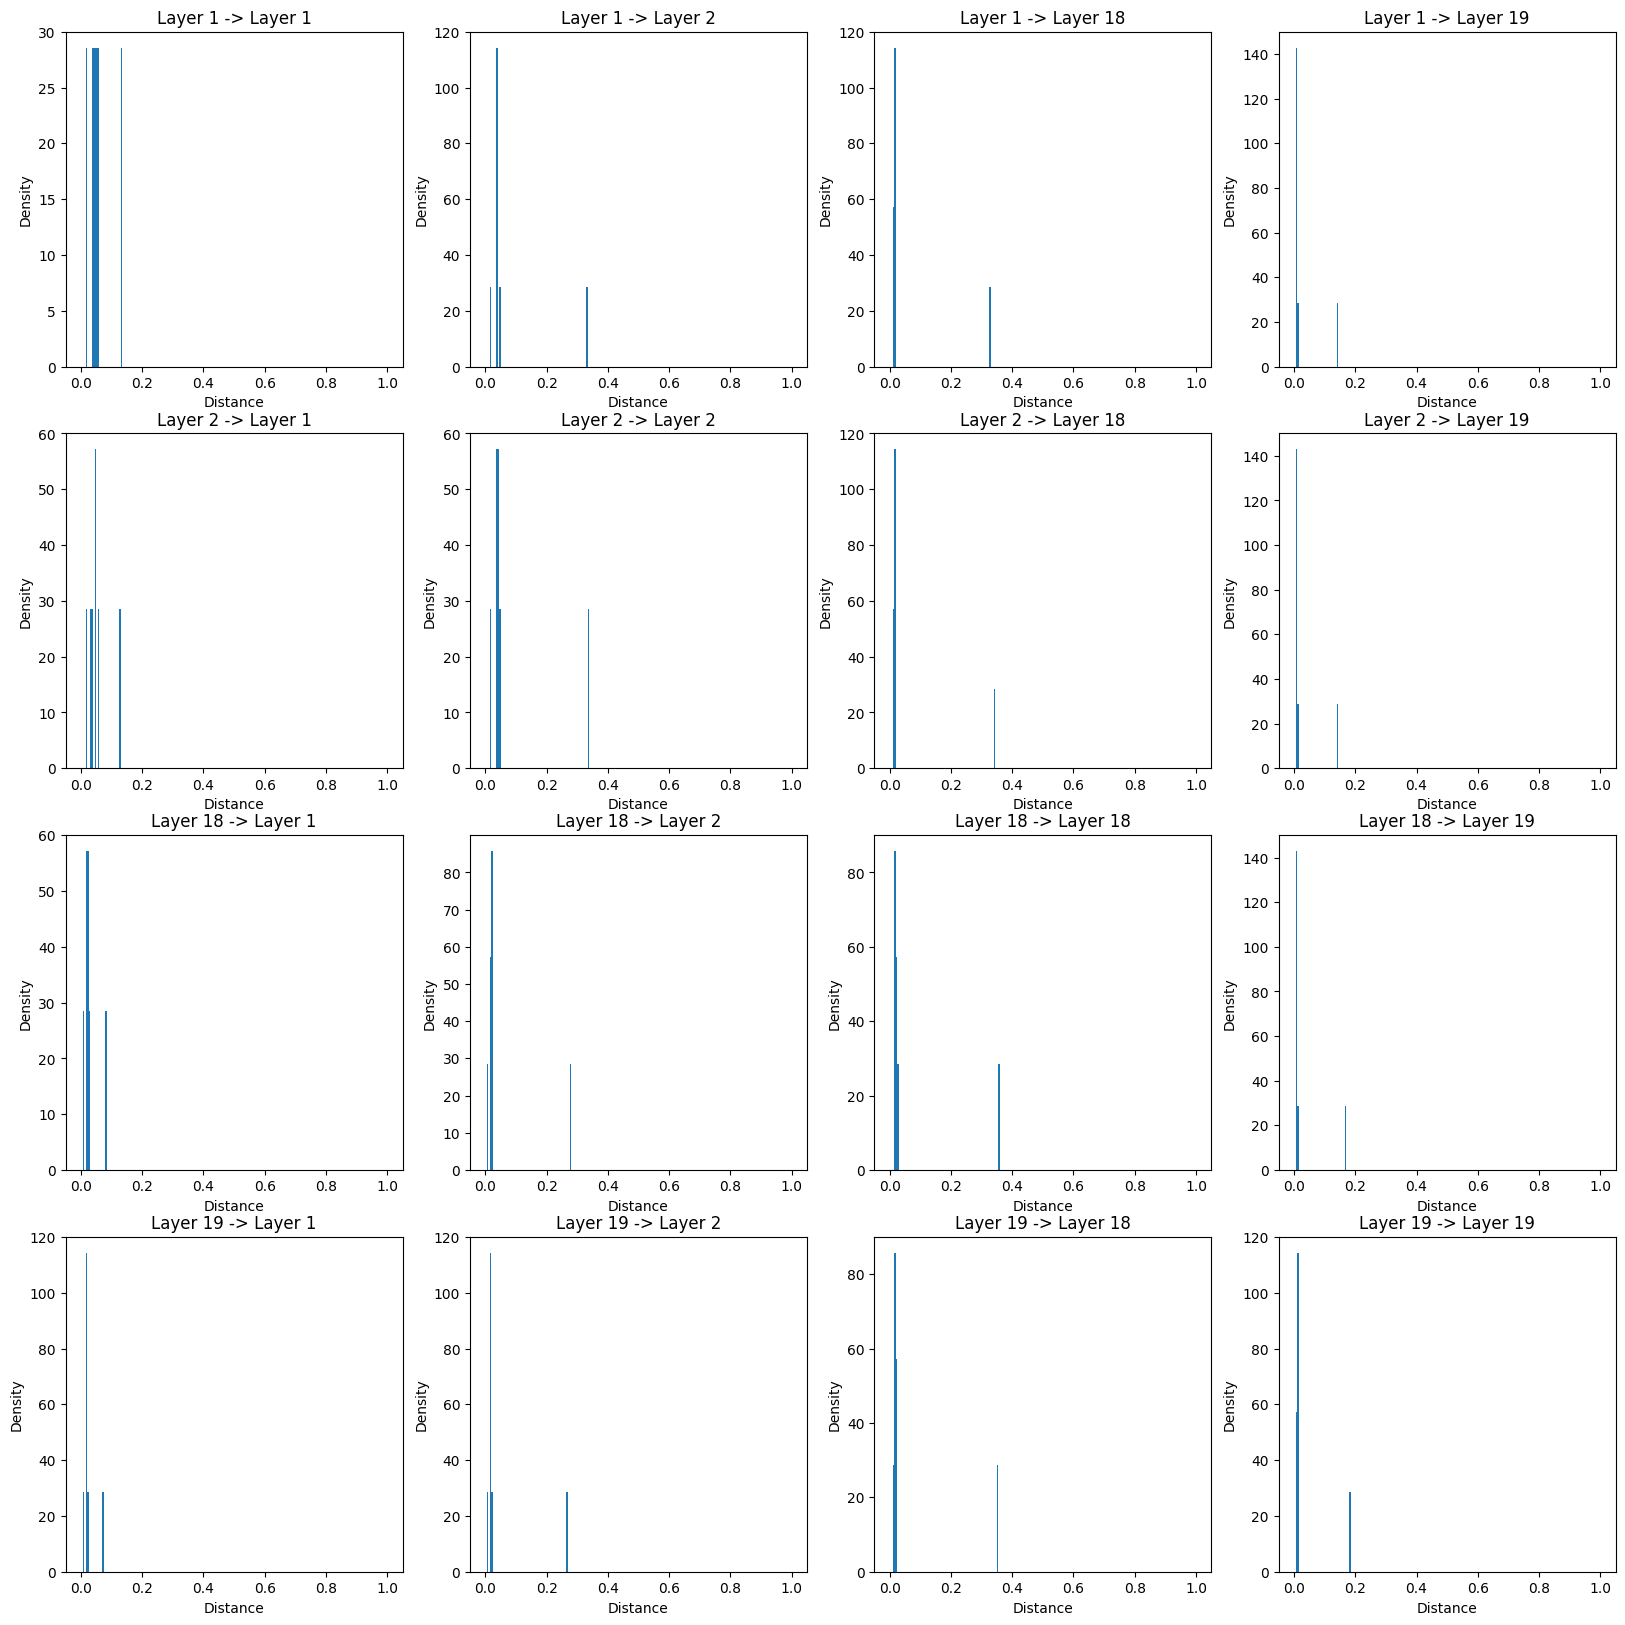

In [24]:
# plot histograms
from matplotlib import pyplot as plt

fig, axs = plt.subplots(len(LAYERS), len(LAYERS), figsize=(20, 20))

print(grids)

for (i, j), samples in grids.items():
    # if i == j:
    #     continue
    layeri_name = LAYERS[i]
    layerj_name = LAYERS[j]
    ax = axs[i, j]

    ax.hist(samples, bins=200, density=True, range=(0, 1))
    ax.set_title(f"Layer {layeri_name} -> Layer {layerj_name}")
    ax.set_xlabel("Distance")
    ax.set_ylabel("Density")

plt.show()


In [38]:
from collections import defaultdict
import numpy as np
from pathlib import Path

from tqdm import tqdm
import features_metric

import importlib
importlib.reload(features_metric)


# tinystories
latent_path = Path("data") / "latents" / "roneneldan/TinyStories" / "latents_9.npy"
latents_TLH = np.load(latent_path)
print(latents_TLH.shape)

T, _, H = latents_TLH.shape

latents_TLH = latents_TLH[np.random.permutation(T)][:100]

grids = defaultdict(list)
sum_max_jaccard_LLH = np.zeros((2, 2, H))

# iterate over strips of hidden dimension
strip_size = 128
n_strips = H // strip_size

for i in tqdm(range(2)):
    for j in range(2):
        for strip_idx in tqdm(range(n_strips), desc=f"Layer {i} -> Layer {j}"):
            start = strip_idx * strip_size
            end = (strip_idx + 1) * strip_size
            latents_sae1_TS = latents_TLH[:, i, start:end]
            latents_sae2_TH = latents_TLH[:, j]

            pairwise_jaccard_similarity_SH = features_metric.pairwise_soft_jaccard(latents_sae1_TS, latents_sae2_TH)
            max_jaccard_S = np.max(pairwise_jaccard_similarity_SH, axis=1)
            assert max_jaccard_S.shape == (strip_size,)
            assert sum_max_jaccard_LLH[i, j, start:end].shape == (strip_size,)
            sum_max_jaccard_LLH[i, j, start:end] += max_jaccard_S

(5120, 4, 16384)


100%|██████████| 2/2 [02:43<00:00, 81.70s/it]


In [37]:
sum_max_jaccard_LLH[i, j, start:end].shape

IndexError: index 2 is out of bounds for axis 1 with size 2

[0.9988 0.6394 0.     ... 0.     0.9999 0.6414]


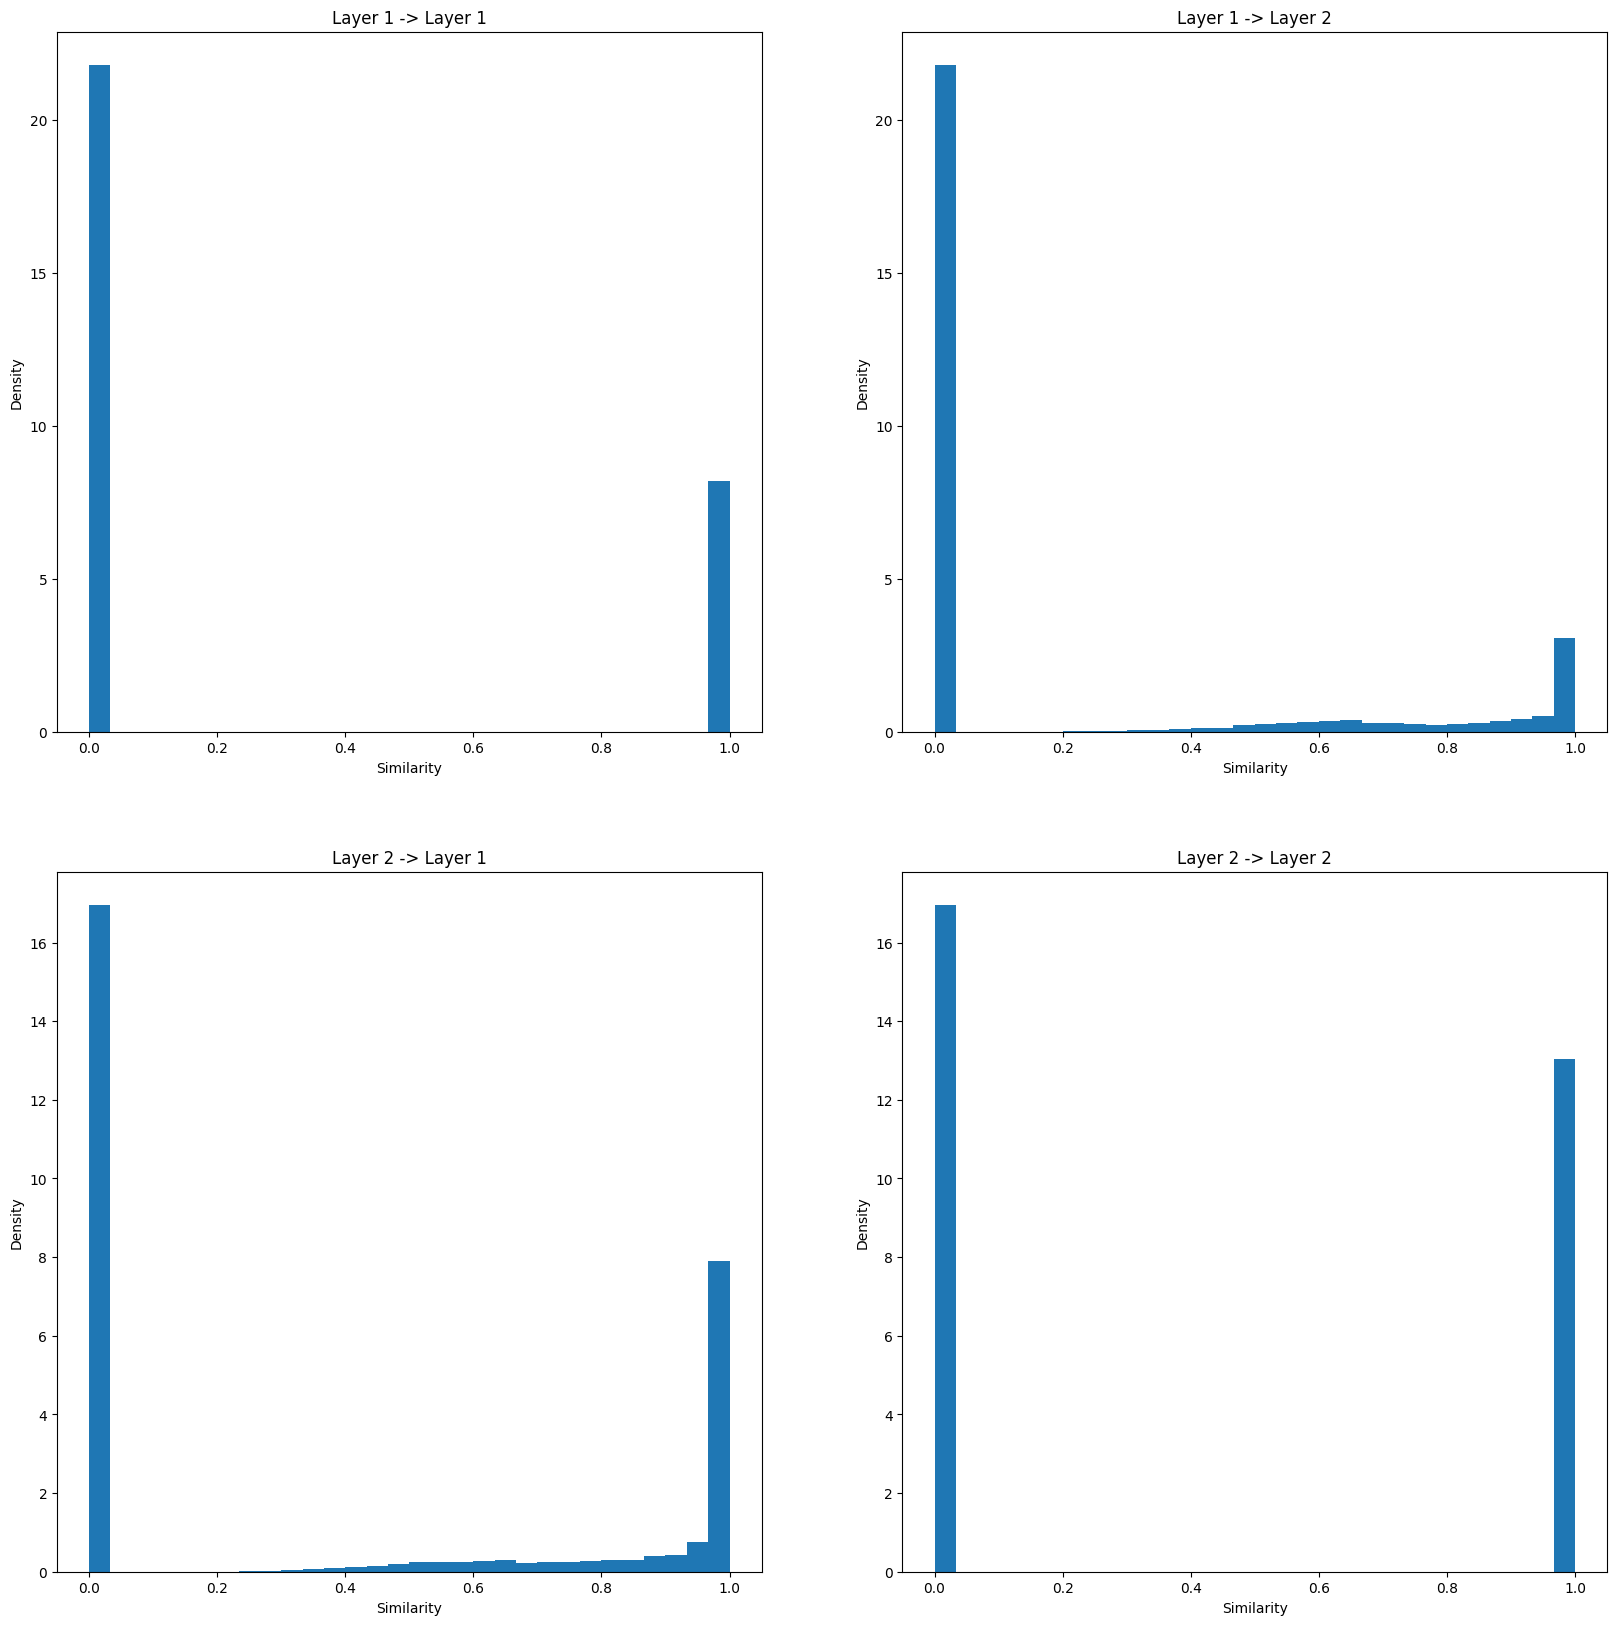

In [39]:
# plot histograms
from matplotlib import pyplot as plt
max_jaccard_H = sum_max_jaccard_H
print(max_jaccard_H)

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        ax.hist(sum_max_jaccard_LLH[i, j], bins=30, density=True, range=(0, 1))
        ax.set_title(f"Layer {LAYERS[i]} -> Layer {LAYERS[j]}")
        ax.set_xlabel("Similarity")
        ax.set_ylabel("Density")
plt.show()